# Imports

In [1]:
import numpy as np, matplotlib.pyplot as plt, librosa as lr, librosa.display
from IPython.display import Audio

# LogFreq

In [2]:
def midi_to_frequency(p):
    return 440 * 2 ** ((p - 69) / 12)

def calc_f_coef(k, sr, N):
    return k * sr / N

def ks_in_dft(p, sr, N):
    ks = []
    num_ks = N // 2
    
    for k in range(num_ks):
        
        f_coef = calc_f_coef(k, sr, N)
        
        if (midi_to_frequency(p - 0.5) < f_coef) and (f_coef < midi_to_frequency(p + 0.5)):
            ks.append(k)
            
    return ks

def stft_to_logfreq(stft, sr):
    logfreq = np.zeros((128, stft.shape[1]))
    window_size = stft.shape[0]

    for p in range(128):
        ks = ks_in_dft(p, sr, window_size)
        logfreq[p, :] = np.sum(np.abs(stft[ks, :]), axis=0)
    
    return logfreq

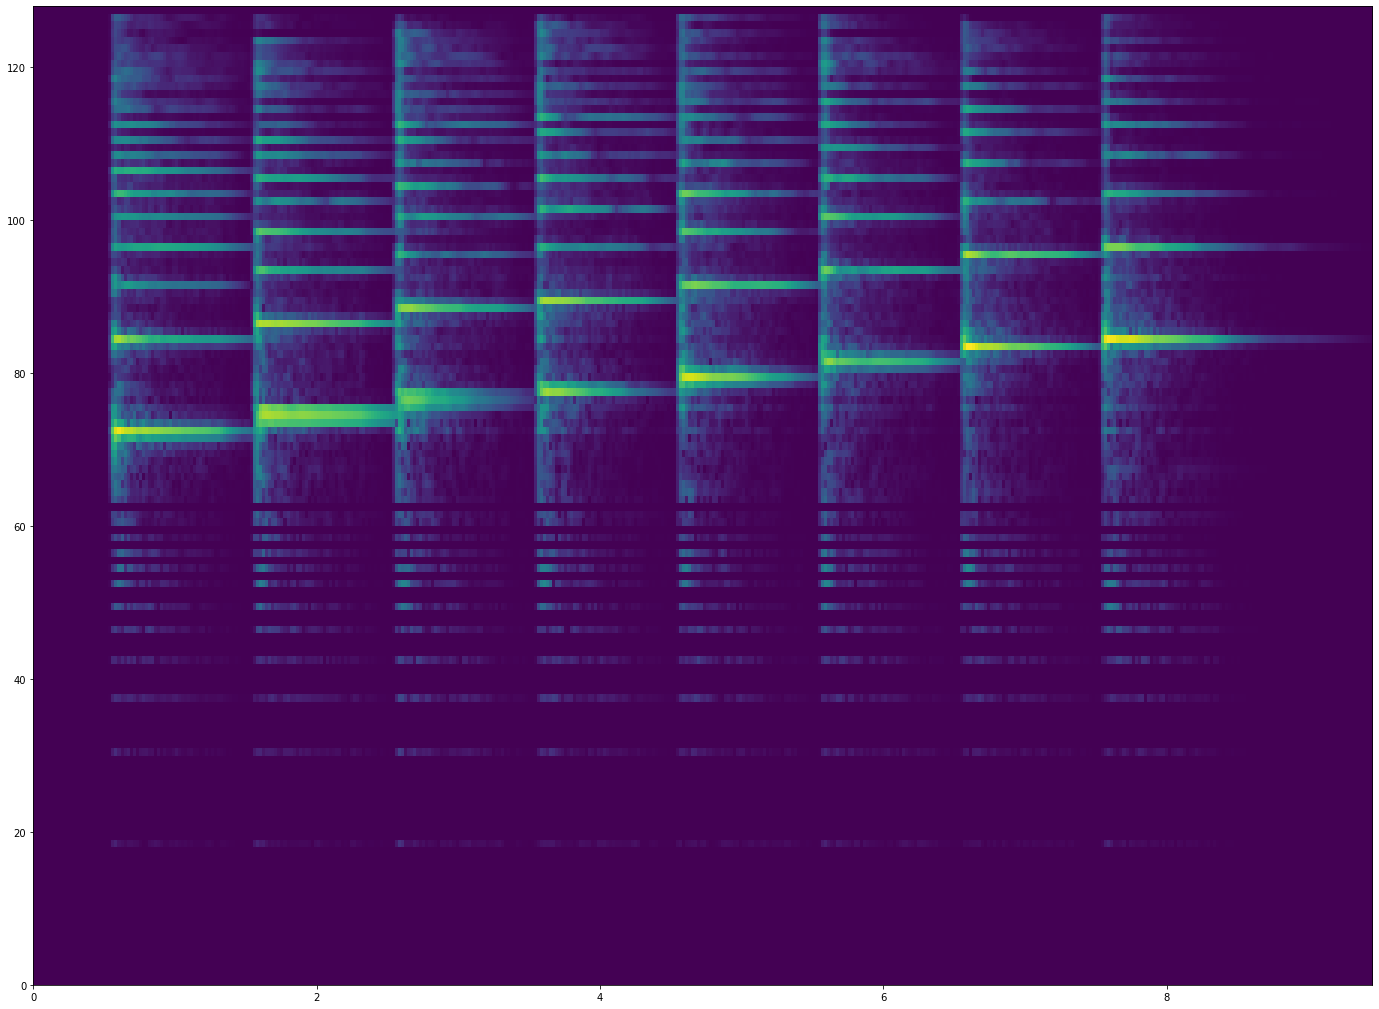

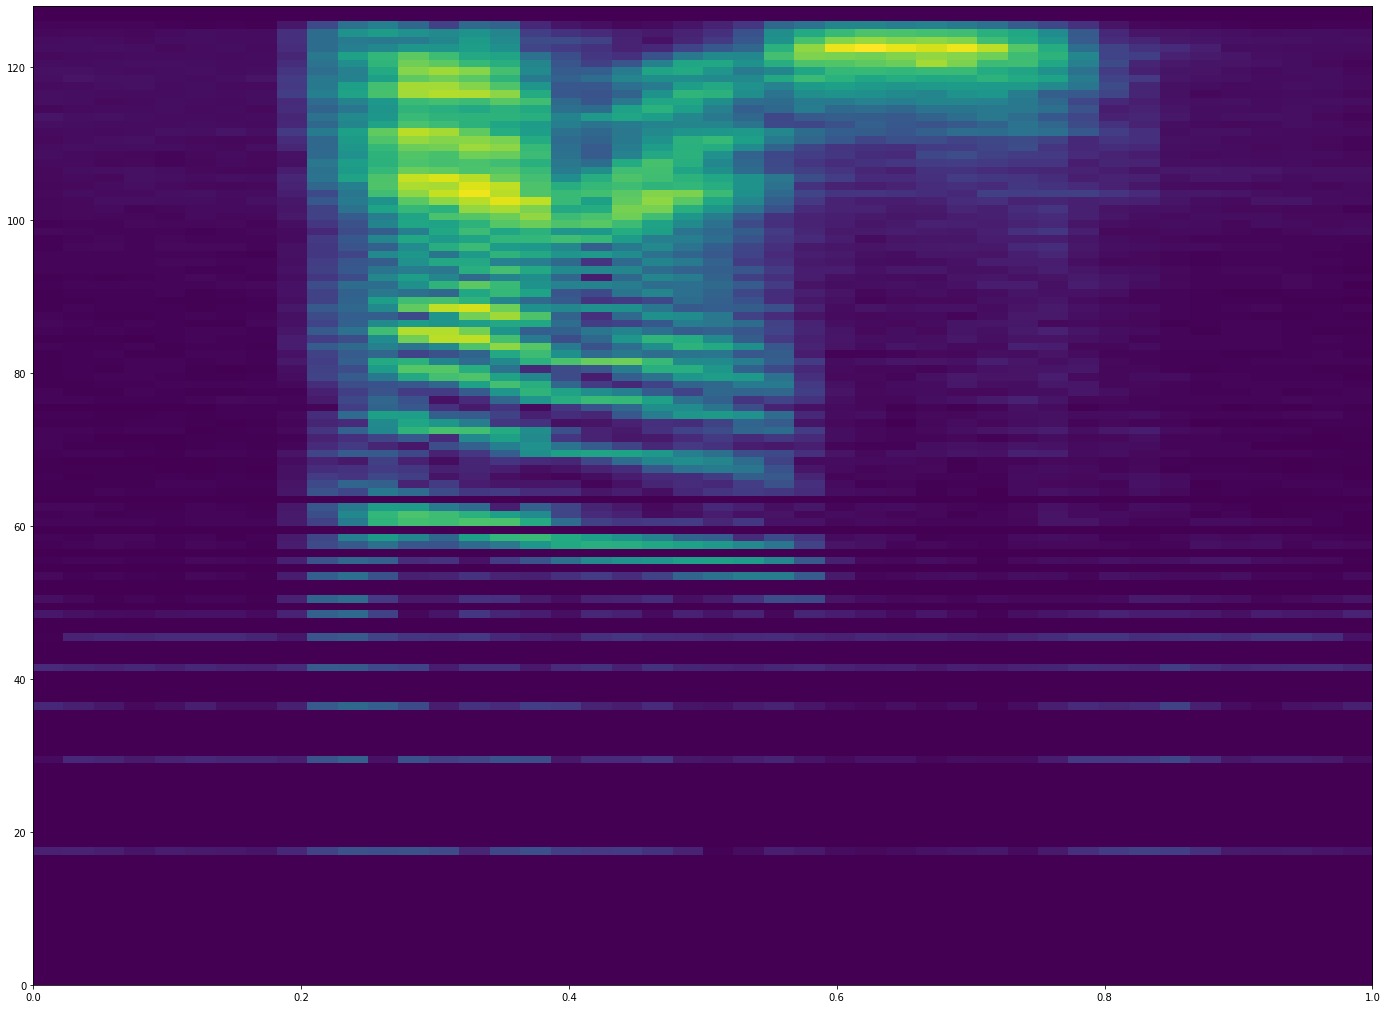

In [3]:
x_piano, sr_piano = lr.load('piano_scale.wav', sr=None)
x_paris, sr_paris = lr.load('paris.wav', sr=None)

length_piano = x_piano.size / sr_piano
length_paris = x_paris.size / sr_paris

display(Audio(x_piano, rate=sr_piano, autoplay=True))
display(Audio(x_paris, rate=sr_paris, autoplay=True))

stft_piano = lr.stft(x_piano)
logfreq_piano = stft_to_logfreq(stft_piano, sr_piano)
stft_paris = lr.stft(x_paris)
logfreq_paris = stft_to_logfreq(stft_paris, sr_paris)


gamma = 1
plt.figure(figsize=(24, 18))
plt.imshow(np.log10(1 + np.abs(logfreq_piano) * gamma), aspect='auto', origin='lower', extent=[0, length_piano, 0, 128])
plt.show()
plt.figure(figsize=(24, 18))
plt.imshow(np.log10(1 + np.abs(logfreq_paris) * gamma), aspect='auto', origin='lower', extent=[0, length_paris, 0, 128])
plt.show()

# Chroma

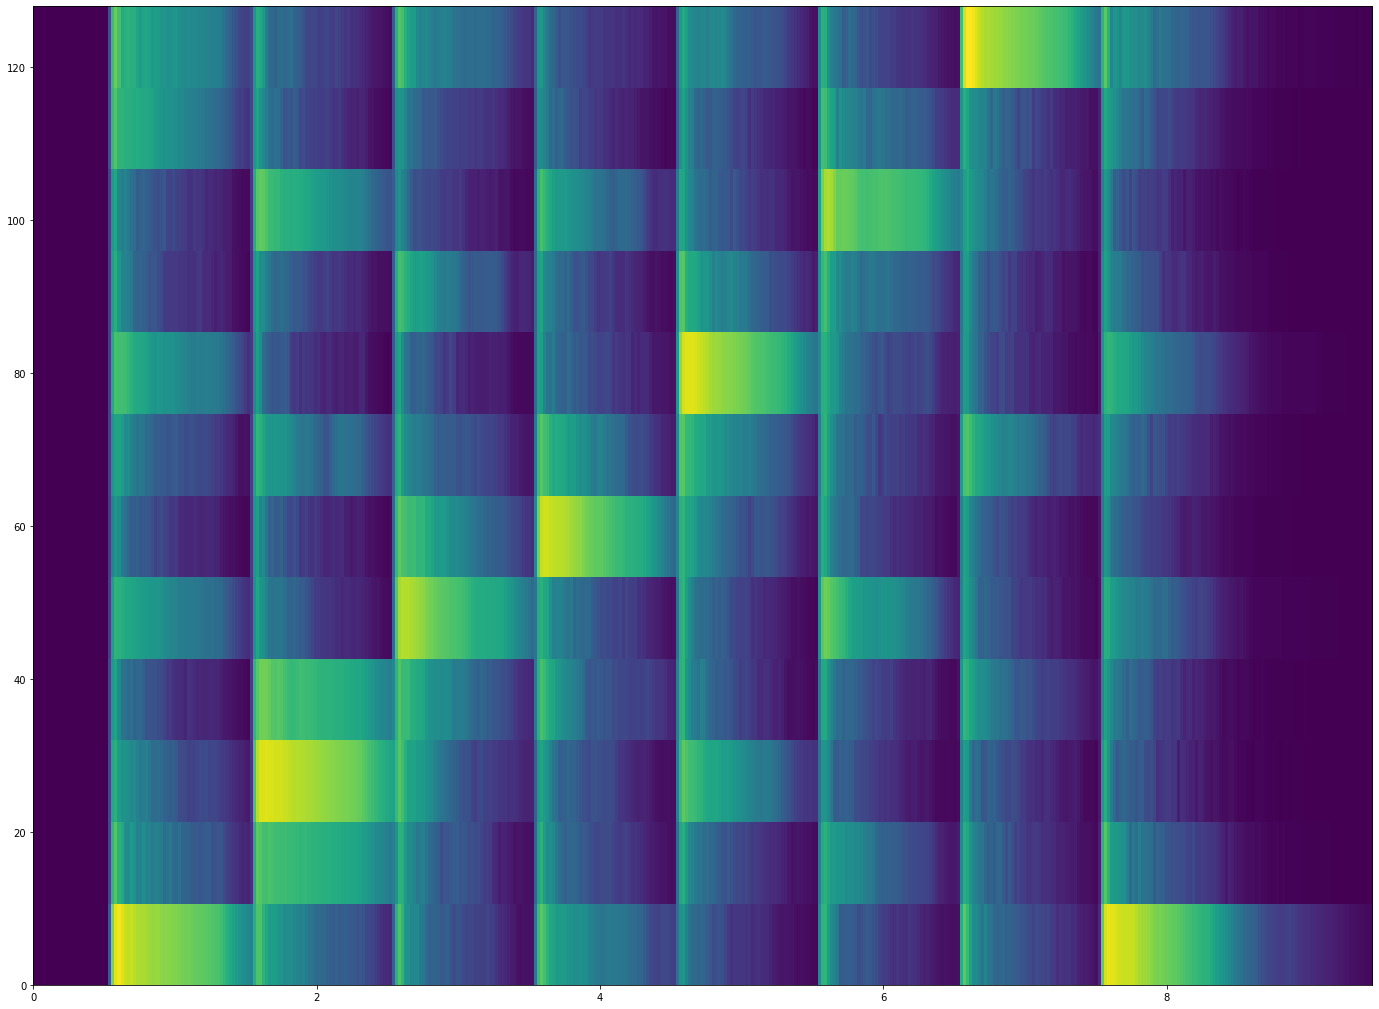

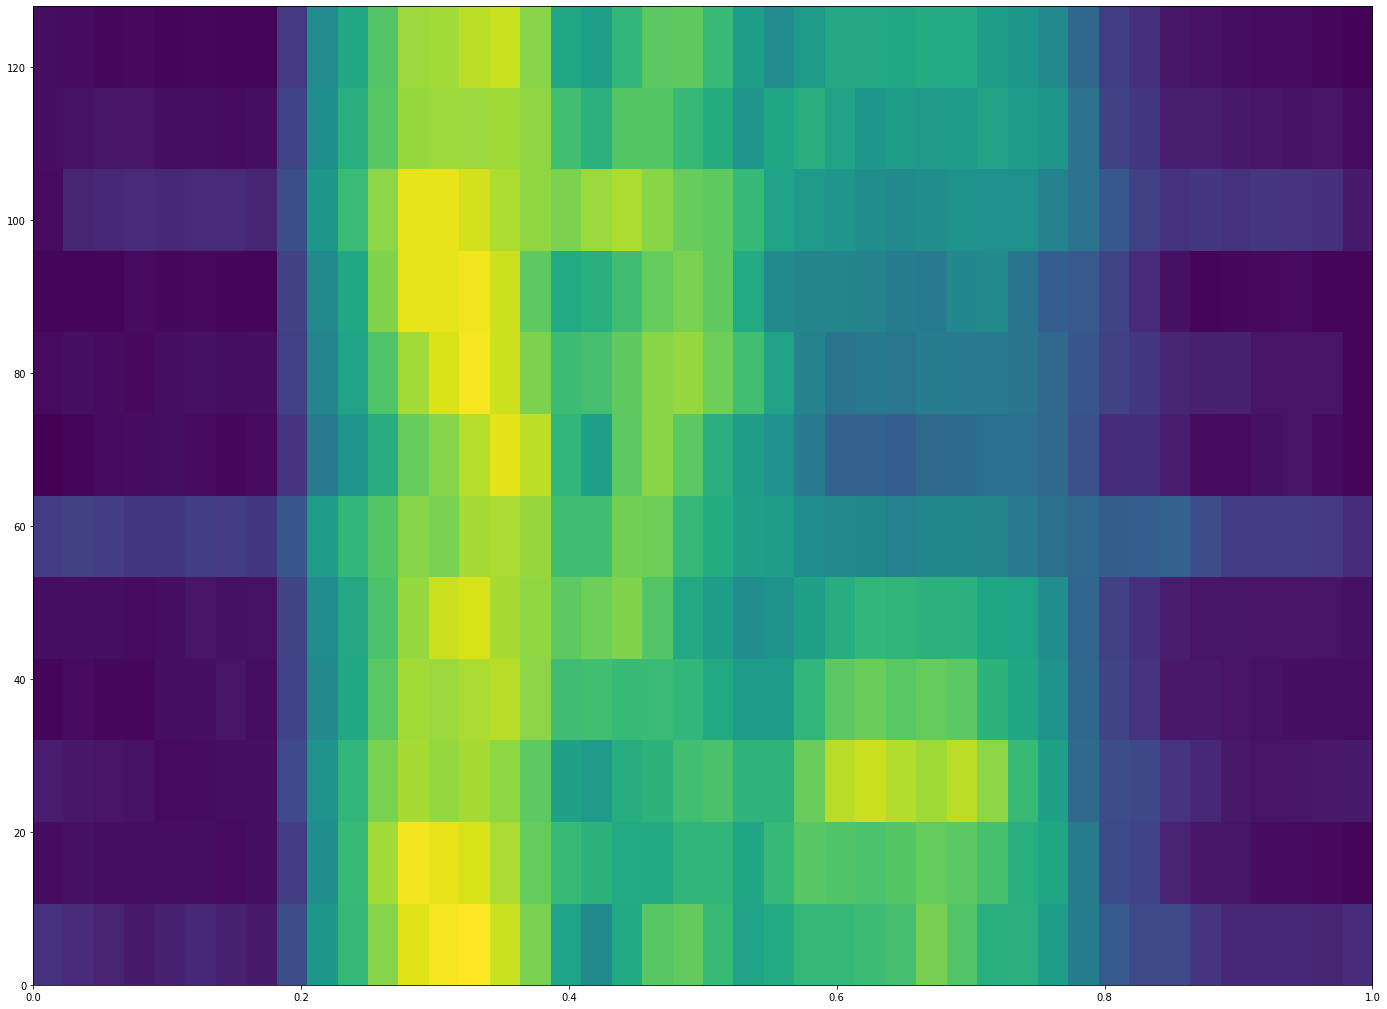

In [4]:
def logfreq_to_chroma(logfreq):
    chroma = np.zeros((12, logfreq.shape[1]))
    for p in range(128):
        chroma[p % 12, :] = chroma[p % 12, :] + logfreq[p, :]
    return chroma

chroma_piano = logfreq_to_chroma(logfreq_piano)
chroma_paris = logfreq_to_chroma(logfreq_paris)

gamma = 1
plt.figure(figsize=(24, 18))
plt.imshow(np.log10(1 + np.abs(chroma_piano) * gamma), aspect='auto', origin='lower', extent=[0, length_piano, 0, 128])
plt.show()
plt.figure(figsize=(24, 18))
 # macht wenig sinn, aber der vollstaendigkeit halber:
plt.imshow(np.log10(1 + np.abs(chroma_paris) * gamma), aspect='auto', origin='lower', extent=[0, length_paris, 0, 128])
plt.show()

# Helpers

In [32]:
def plot_feature_waveform(feature, x, normalize=True):
    plt.subplot(2, 1, 1)
    plt.plot(x)
    t = np.linspace(0, x.size, feature.size)
    if normalize:
        plt.plot(t, feature / np.max(np.abs(feature)))
    else:
        plt.plot(t, feature)
    plt.ylim(-1.1, 1.1)
    plt.subplot(2, 1, 2)
    plt.plot(feature)
    plt.tight_layout()
    plt.show()
    
def plot_feature_stft(feature, stft, sr, gamma=1):
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    lr.display.specshow(np.log(1 + stft * gamma), y_coords=lr.fft_frequencies(sr, 2048))
    plt.plot(feature)
    plt.show()

In [15]:
a = np.arange(30)

print(a, '\n')

a_framed = lr.util.frame(a, 6, 2)

print(a_framed, '\n')

np.sum(a_framed, axis=0)

# 15, 27, 39, ...

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29] 

[[ 0  2  4  6  8 10 12 14 16 18 20 22 24]
 [ 1  3  5  7  9 11 13 15 17 19 21 23 25]
 [ 2  4  6  8 10 12 14 16 18 20 22 24 26]
 [ 3  5  7  9 11 13 15 17 19 21 23 25 27]
 [ 4  6  8 10 12 14 16 18 20 22 24 26 28]
 [ 5  7  9 11 13 15 17 19 21 23 25 27 29]] 



array([ 15,  27,  39,  51,  63,  75,  87,  99, 111, 123, 135, 147, 159])

# Root Mean Square Energy (Wiederholung)

${\displaystyle rms = \sqrt{\dfrac{1}{n} \sum^{n}_{i=1}x_{i}^{2}} = \sqrt{\dfrac{x_{1}^{2} + x_{2}^{2} + ... + x_{n}^{2}}{n}}}$

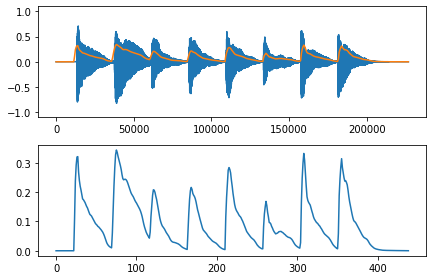

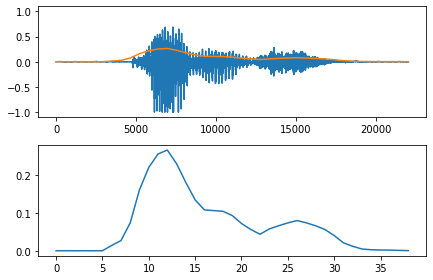

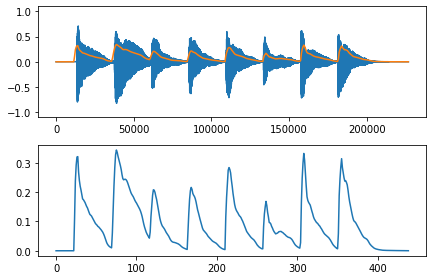

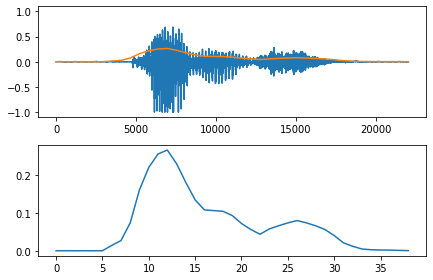

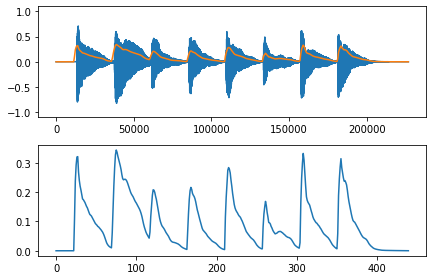

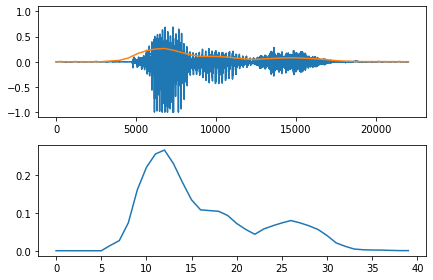

In [20]:
def calc_rms_energy_double_loop(x, hop_size=512, window_size=2048):
    num_windows = (x.size - window_size) // hop_size
    rms = np.zeros(num_windows)
    for i in range(num_windows):
        for win_samp_idx in range(window_size):
            rms[i] += x[i * hop_size + win_samp_idx] ** 2 / window_size
    rms = np.sqrt(rms)
    return rms

rms_piano = calc_rms_energy_double_loop(x_piano)
plot_feature_waveform(rms_piano, x_piano, normalize=False)
rms_paris = calc_rms_energy_double_loop(x_paris)
plot_feature_waveform(rms_paris, x_paris, normalize=False)

def calc_rms_energy_loop(x, hop_size=512, window_size=2048):
    num_windows = (x.size - window_size) // hop_size
    rms = np.zeros(num_windows)
    for i in range(num_windows):
        win = x[i * hop_size : i * hop_size + window_size]
        rms[i] = np.sqrt(np.mean(win ** 2))
    return rms

rms_piano = calc_rms_energy_loop(x_piano)
plot_feature_waveform(rms_piano, x_piano, normalize=False)
rms_paris = calc_rms_energy_loop(x_paris)
plot_feature_waveform(rms_paris, x_paris, normalize=False)


def calc_rms_energy_framed(x, hop_size=512, window_size=2048):
    x_framed = lr.util.frame(x, window_size, hop_size)
    rms = np.sqrt(np.mean(x_framed ** 2, axis=0))
    return rms

rms_piano = calc_rms_energy_framed(x_piano)
plot_feature_waveform(rms_piano, x_piano, normalize=False)
rms_paris = calc_rms_energy_framed(x_paris)
plot_feature_waveform(rms_paris, x_paris, normalize=False)

In [21]:
%timeit calc_rms_energy_double_loop(x_piano)
%timeit calc_rms_energy_loop(x_piano)
%timeit calc_rms_energy_framed(x_piano)

1 loop, best of 5: 3.29 s per loop
100 loops, best of 5: 7.97 ms per loop
1000 loops, best of 5: 1.04 ms per loop


# Zero-Crossing-Rate

${\displaystyle zcr = {\frac{1}{N}\sum^{N}_{i = 1} | \mathrm{sign}[x(n + i)] - \mathrm{sign}[x(n + i - 1)]|}}$

${\displaystyle zcr = {\frac{1}{N}\sum^{N}_{i = 1} | \mathrm{sign}[x(n + i + 1)] - \mathrm{sign}[x(n + i)]|}}$

$
\mathrm{sign}(x) = \left\{
\begin{array}{ll}
    +1 & \mathrm{if} \ x > 0\\
    0  & \mathrm{if} \ x = 0\\
    -1 & \mathrm{if} \ x < 0
\end{array}
\right.
$

In [26]:
print(np.sign(-100239))
print(np.sign(100239))
print(np.sign(0))


np.arange(10)

-1
1
0


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

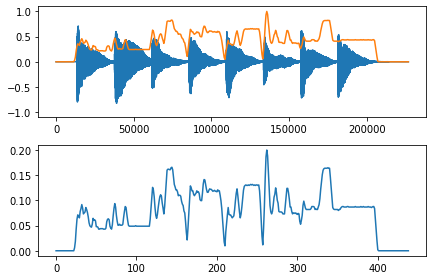

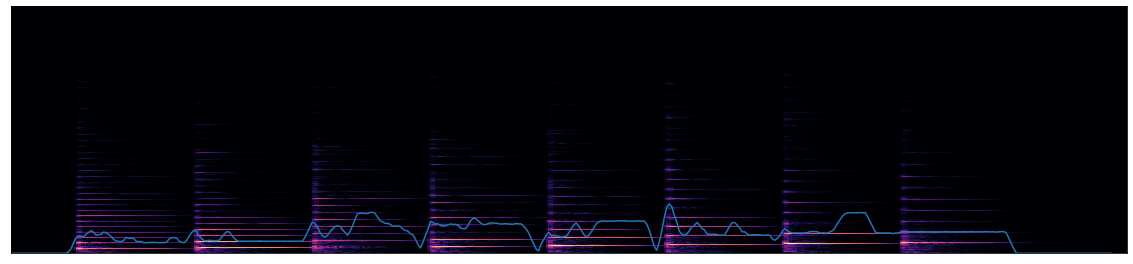

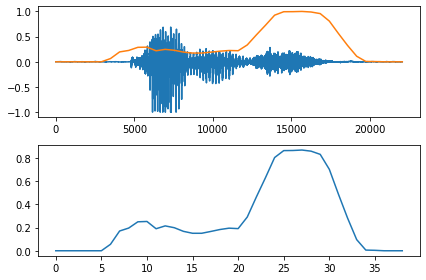

In [33]:
def calc_zero_crossing_rate(x, hop_size=512, window_size=2048):
    num_windows = (x.size - window_size) // hop_size
    zcr = np.zeros(num_windows)
    for i in range(num_windows):
        win = x[i * hop_size : i * hop_size + window_size]
        zcr[i] = np.mean(np.abs(np.sign(win[1:]) - np.sign(win[:-1])))
    return zcr

zcr_piano = calc_zero_crossing_rate(x_piano + 0.01)
plot_feature_waveform(zcr_piano, x_piano)
plot_feature_stft(zcr_piano * sr_piano / 2, np.abs(stft_piano), sr_piano)
zcr_paris = calc_zero_crossing_rate(x_paris + 0.01)
plot_feature_waveform(zcr_paris, x_paris)

# Spectral Centroid

Schwerpunkt der Magnituden-Frequenzen im FFT-Fenster.

${\displaystyle \mathrm{centroid} = \dfrac{\sum^{N-1}_{k=0}\mathrm{freqs}(n)X(k)}{\sum^{N-1}_{k=0}X(k)}}$

In [39]:
f = np.arange(1, 7)

print(f)

print(a_framed)

print(f[:, np.newaxis] * a_framed)

[1 2 3 4 5 6]
[[ 0  2  4  6  8 10 12 14 16 18 20 22 24]
 [ 1  3  5  7  9 11 13 15 17 19 21 23 25]
 [ 2  4  6  8 10 12 14 16 18 20 22 24 26]
 [ 3  5  7  9 11 13 15 17 19 21 23 25 27]
 [ 4  6  8 10 12 14 16 18 20 22 24 26 28]
 [ 5  7  9 11 13 15 17 19 21 23 25 27 29]]
[[  0   2   4   6   8  10  12  14  16  18  20  22  24]
 [  2   6  10  14  18  22  26  30  34  38  42  46  50]
 [  6  12  18  24  30  36  42  48  54  60  66  72  78]
 [ 12  20  28  36  44  52  60  68  76  84  92 100 108]
 [ 20  30  40  50  60  70  80  90 100 110 120 130 140]
 [ 30  42  54  66  78  90 102 114 126 138 150 162 174]]


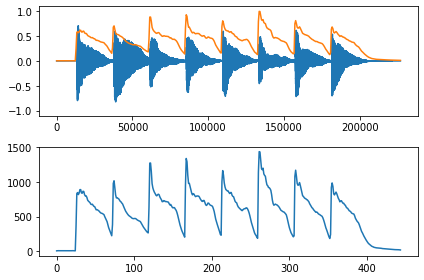

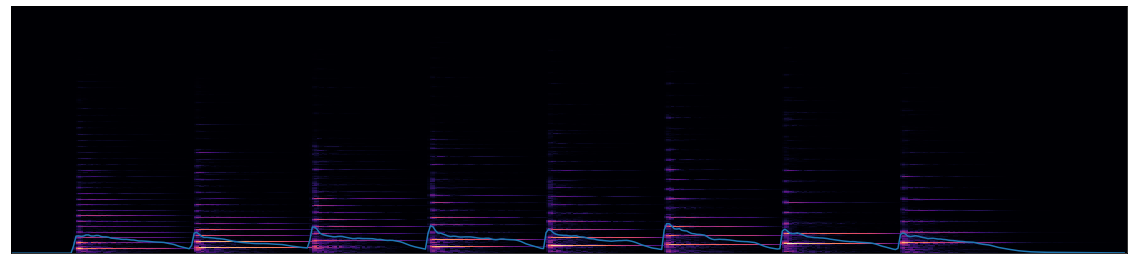

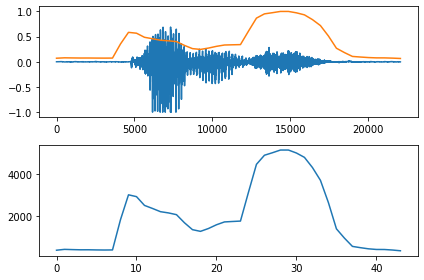

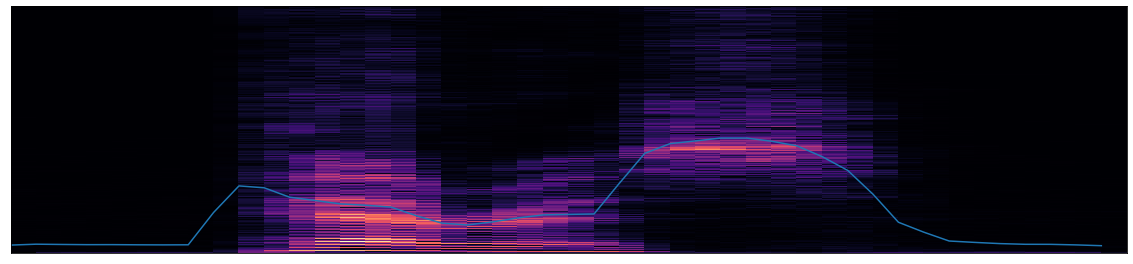

In [42]:
def calc_spectral_centroid(stft, sr):
    freqs = lr.fft_frequencies(sr, stft.shape[0] * 2 - 1)
    spec_cent = np.sum(freqs[:, np.newaxis] * stft, axis=0) / np.sum(stft, axis=0)
    return spec_cent

spec_cent_piano = calc_spectral_centroid(np.abs(lr.stft(x_piano + 0.05)), sr_piano)
plot_feature_waveform(spec_cent_piano, x_piano)
plot_feature_stft(spec_cent_piano, np.abs(stft_piano), sr_piano)

spec_cent_paris = calc_spectral_centroid(np.abs(lr.stft(x_paris + 0.05)), sr_paris)
plot_feature_waveform(spec_cent_paris, x_paris)
plot_feature_stft(spec_cent_paris, np.abs(stft_paris), sr_paris)

# Spectral Bandwidth / Spread

Deutet die "Breite", bzw. Verteilung der energiereichen/energie-gleichen Frequenzkoeffizienten des Spektrums zu einem Zeitpunkt im Fenster an.

${\displaystyle \mathrm{bandwidth} = \sqrt{\dfrac{\sum_{n=0}^{N-1}(\mathrm{freqs}(n) - \mathrm{centroid})^2X(n)}{\sum_{n=0}^{N-1}X(n)}}}$

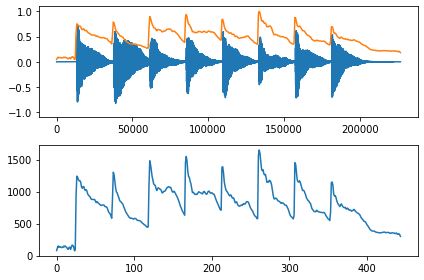

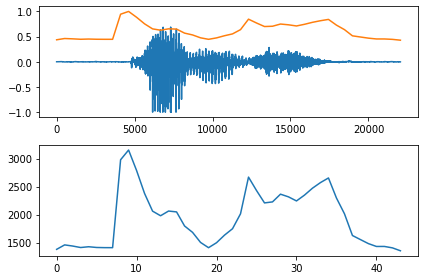

In [45]:
def calc_spectral_bandwidth(stft, sr):
    freqs = lr.fft_frequencies(sr, stft.shape[0] * 2 - 1)
    spec_cent = calc_spectral_centroid(stft, sr)
    spec_band = np.sqrt(np.sum( ((freqs[:, np.newaxis] - spec_cent) ** 2) * stft , axis=0) / np.sum(stft, axis=0))
    return spec_band

spec_band_piano = calc_spectral_bandwidth(np.abs(lr.stft(x_piano + 0.05)), sr_piano)
plot_feature_waveform(spec_band_piano, x_piano)
spec_band_paris = calc_spectral_bandwidth(np.abs(lr.stft(x_paris + 0.05)), sr_paris)
plot_feature_waveform(spec_band_paris, x_paris)

## Combined Visualisation

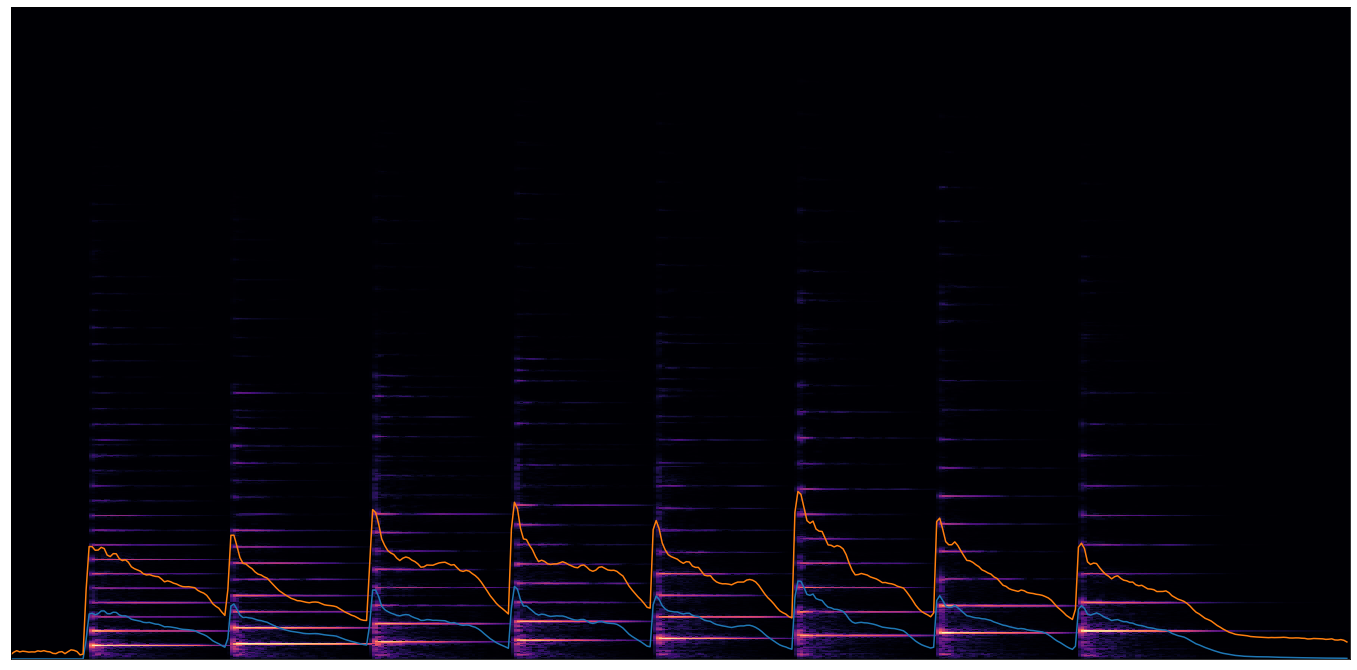

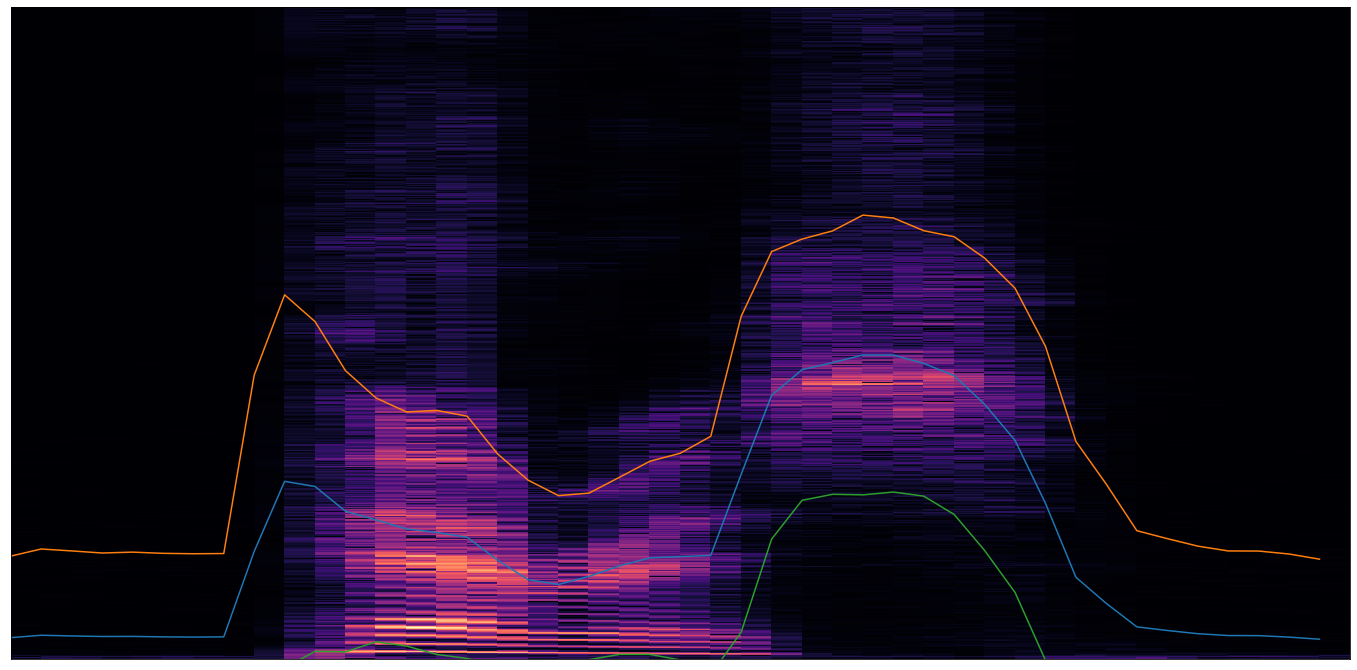

In [46]:
# t_piano = np.linspace(0, x_piano.size, spec_band_piano.size)
plt.figure(figsize=(24, 12))
lr.display.specshow(np.log(1 + np.abs(stft_piano)), y_coords=lr.fft_frequencies(sr_piano, 2048))
spec_cent_piano = calc_spectral_centroid(np.abs(lr.stft(x_piano + 0.05)), sr_piano)
plt.plot(spec_cent_piano)
plt.plot(spec_cent_piano + spec_band_piano)
plt.plot(spec_cent_piano - spec_band_piano)
plt.show()

# t_piano = np.linspace(0, x_piano.size, spec_band_piano.size)
plt.figure(figsize=(24, 12))
lr.display.specshow(np.log(1 + np.abs(stft_paris)), y_coords=lr.fft_frequencies(sr_paris, 2048))
spec_cent_paris = calc_spectral_centroid(np.abs(lr.stft(x_paris + 0.05)), sr_paris)
plt.plot(spec_cent_paris)
plt.plot(spec_cent_paris + spec_band_paris)
plt.plot(spec_cent_paris - spec_band_paris)
plt.show()